# Train a Deep NN to predict Asset Price returns

In practice, we need to explore variations of the design options outlined above because we can rarely be sure from the outset which network architecture best suits the data.

In this section, we will explore various options to build a simple feedforward Neural Network to predict asset price returns for a one-day horizon.

## Setup Docker for GPU acceleration

`docker run -it -p 8889:8888 -v /path/to/machine-learning-for-trading/16_convolutions_neural_nets/cnn:/cnn --name tensorflow tensorflow/tensorflow:latest-gpu-py3 bash`

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os, sys
from time import time
from pathlib import Path
from importlib import reload
from joblib import dump, load
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import load_model

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
np.random.seed(42)
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [145]:
DATA_STORE = '../data/assets.h5'

## Create a stock return series to predict asset price moves

To develop our trading strategy, we use the daily stock returns for some 995 US stocks for the eight year period from 2010 to 2017, and the features developed in Chapter 12 that include volatility and momentum factors as well as lagged returns with cross-sectional and sectoral rankings.

In [6]:
data = pd.read_hdf('../12_gradient_boosting_machines/data/data.h5', 'model_data').dropna()

In [7]:
outcomes = data.filter(like='fwd').columns.tolist()

In [8]:
lookahead = 1
outcome= f'r{lookahead:02}_fwd'

In [12]:
X = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
y = data.loc[idx[:, :'2017'], outcome]

In [13]:
len(X.index.get_level_values('symbol').unique())

995

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1911344 entries, ('A', Timestamp('2010-04-06 00:00:00')) to ('ZION', Timestamp('2017-11-29 00:00:00'))
Data columns (total 30 columns):
 #   Column           Dtype  
---  ------           -----  
 0   dollar_vol_rank  float64
 1   rsi              float64
 2   bb_high          float64
 3   bb_low           float64
 4   NATR             float64
 5   ATR              float64
 6   PPO              float64
 7   MACD             float64
 8   sector           int64  
 9   r01              float64
 10  r05              float64
 11  r10              float64
 12  r21              float64
 13  r42              float64
 14  r63              float64
 15  r01dec           float64
 16  r05dec           float64
 17  r10dec           float64
 18  r21dec           float64
 19  r42dec           float64
 20  r63dec           float64
 21  r01q_sector      float64
 22  r05q_sector      float64
 23  r10q_sector      float64
 24  r21q_sector      float64
 25 

## Automate model generation

The following `make_model` function illustrates how to flexibly define various architectural elements for the search process. The dense_layers argument defines both the depth and width of the network as a list of integers. We also use dropout for regularization, expressed as a float in the range [0, 1] to define the probability that a given unit will be excluded from a training iteration.

In [15]:
def make_model(dense_layers, activation, dropout):
    '''Creates a multi-layer perceptron model
    
    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=X_cv.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(layer_size))
            model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='Adam')

    return model

## Cross-validate multiple configurations with TensorFlow

### Train-Test Split

We split the data into a training set for cross-validation, and keep the last 12 months with data as holdout test:

In [16]:
n_splits = 12
train_period_length=21 * 12 * 4
test_period_length=21 * 3

In [17]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

### Define CV Parameters

Now we just need to define our Keras classifier using the make_model function, set cross-validation (see chapter 6 on The Machine Learning Process and following for the OneStepTimeSeriesSplit), and the parameters that we would like to explore. 

We pick several one- and two-layer configurations, relu and tanh activation functions, and different dropout rates. We could also try out different optimizers (but did not run this experiment to limit what is already a computationally intensive effort):

In [18]:
dense_layer_opts = [(16, 8), (32, 16), (32, 32), (64, 32)]
activation_opts = ['tanh']
dropout_opts = [0, .1, .2]

In [19]:
param_grid = list(product(dense_layer_opts, activation_opts, dropout_opts))
np.random.shuffle(param_grid)

In [20]:
len(param_grid)

12

To trigger the parameter search, we instantiate a GridSearchCV object, define the fit_params that will be passed to the Keras model’s fit method, and provide the training data to the GridSearchCV fit method:

In [21]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    return x_train, y_train, x_val, y_val

In [22]:
checkpoint_dir = Path('logs')

In [ ]:
ic = []
scaler = StandardScaler()
for params in param_grid:
    dense_layers, activation, dropout = params
    for batch_size in [64, 256]:
        print(dense_layers, activation, dropout, batch_size)
        checkpoint_path = checkpoint_dir / str(dense_layers) / activation / str(dropout) / str(batch_size)
        if not checkpoint_path.exists():
            checkpoint_path.mkdir(parents=True, exist_ok=True)
        start = time()
        for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
            x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.transform(x_val)
            preds = y_val.to_frame('actual')
            r = pd.DataFrame(index=y_val.groupby(level='date').size().index)
            model = make_model(dense_layers, activation, dropout)
            for epoch in range(20):            
                model.fit(x_train,
                          y_train,
                          batch_size=batch_size,
                          epochs=1,
                          verbose=0,
                          shuffle=True,
                          validation_data=(x_val, y_val))
                model.save_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
                preds[epoch] = model.predict(x_val).squeeze()
                r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
                print(format_time(time()-start), f'{fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
            ic.append(r.assign(dense_layers=str(dense_layers), 
                               activation=activation, 
                               dropout=dropout,
                               batch_size=batch_size,
                               fold=fold))       

        t = time()-start
        pd.concat(ic).to_hdf('scores.h5', 'ic_by_day')

### Evaluate predictive performance

In [96]:
params = ['dense_layers', 'dropout', 'batch_size']

In [123]:
ic = pd.read_hdf('scores.h5', 'ic_by_day').drop('activation', axis=1)
ic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16632 entries, 2017-08-30 to 2015-03-02
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   0             16632 non-null  float64
 1   1             16632 non-null  float64
 2   2             16632 non-null  float64
 3   3             16632 non-null  float64
 4   4             16632 non-null  float64
 5   5             16632 non-null  float64
 6   6             16632 non-null  float64
 7   7             16632 non-null  float64
 8   8             16632 non-null  float64
 9   9             16632 non-null  float64
 10  10            16632 non-null  float64
 11  11            16632 non-null  float64
 12  12            16632 non-null  float64
 13  13            16632 non-null  float64
 14  14            16632 non-null  float64
 15  15            16632 non-null  float64
 16  16            16632 non-null  float64
 17  17            16632 non-null  float64
 18  18       

In [98]:
ic.groupby(params).size()

dense_layers  dropout  batch_size
(16, 8)       0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(32, 16)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(32, 32)      0.1      64            756
                       256           756
              0.2      64            756
                       256           756
(64, 32)      0.0      64            756
                       256           756
              0.1      64            756
                       256           756
              0.2      64            756
                       256           756
dtype: int64

In [124]:
ic_long = pd.melt(ic, id_vars=params + ['fold'], var_name='epoch', value_name='ic')
ic_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332640 entries, 0 to 332639
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   dense_layers  332640 non-null  object 
 1   dropout       332640 non-null  float64
 2   batch_size    332640 non-null  int64  
 3   fold          332640 non-null  int64  
 4   epoch         332640 non-null  object 
 5   ic            332640 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 15.2+ MB


In [104]:
ic_long = ic_long.groupby(params+ ['epoch', 'fold']).ic.mean().to_frame('ic').reset_index()

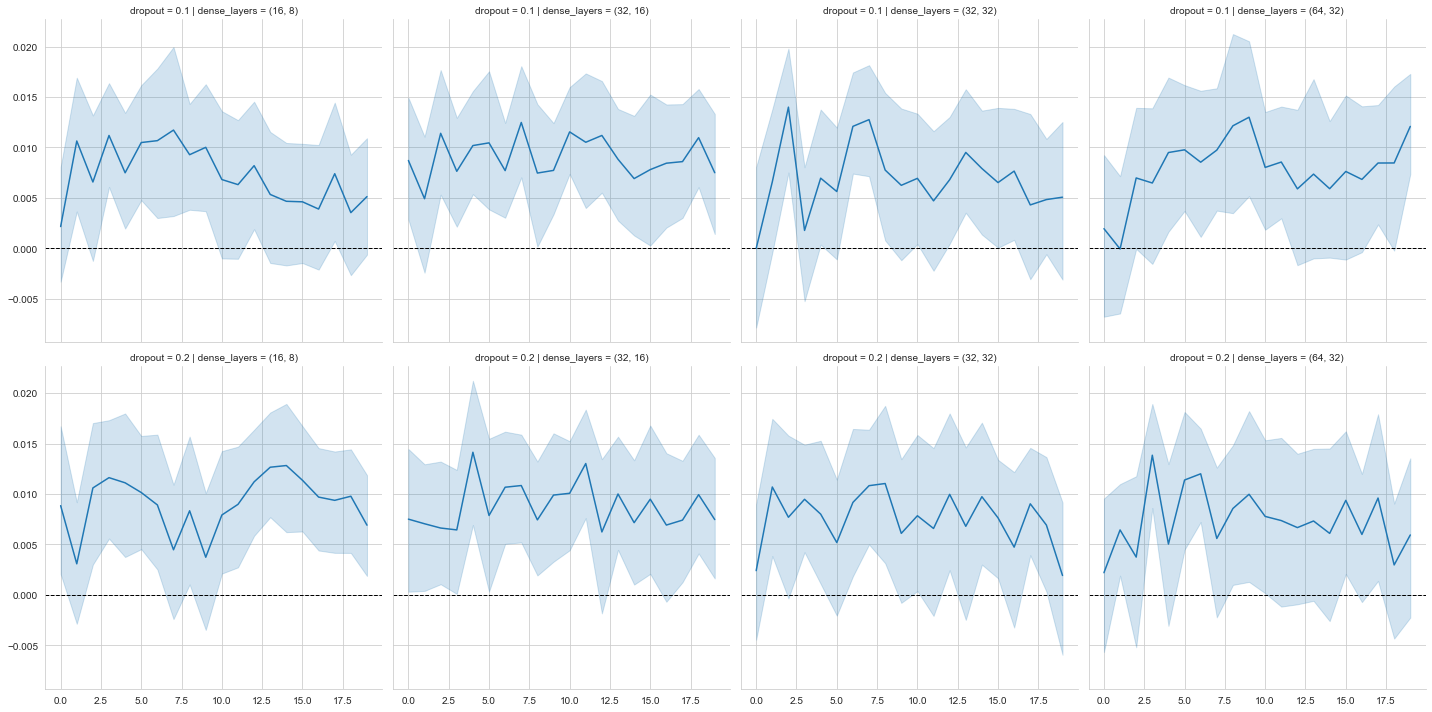

In [115]:
g = sns.relplot(x='epoch', y='ic', col='dense_layers', row='dropout', 
                data=ic_long[ic_long.dropout>0], kind='line')
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig('figures/ic_lineplot', dpi=300);

In [116]:
def run_ols(ic):
    ic.dense_layers = ic.dense_layers.str.replace(', ', '-').str.replace('(', '').str.replace(')', '')
    data = pd.melt(ic, id_vars=params, var_name='epoch', value_name='ic')
    data.epoch = data.epoch.astype(int).astype(str).apply(lambda x: f'{int(x):02.0f}')
    model_data = pd.get_dummies(data.sort_values(params + ['epoch']), columns=['epoch'] + params, drop_first=True).sort_index(1)
    model_data.columns = [s.split('_')[-1] for s in model_data.columns]
    model = sm.OLS(endog=model_data.ic, exog=sm.add_constant(model_data.drop('ic', axis=1)))
    return model.fit()

In [ ]:
model = run_ols(ic.drop('fold', axis=1))

In [142]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     ic   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.887
Date:                Tue, 17 Mar 2020   Prob (F-statistic):            0.00469
Time:                        19:43:10   Log-Likelihood:             2.1500e+05
No. Observations:              332640   AIC:                        -4.299e+05
Df Residuals:                  332614   BIC:                        -4.297e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.376      0.0

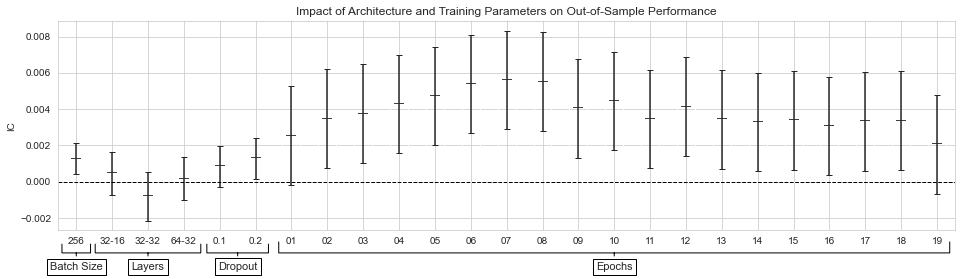

In [121]:
fig, ax = plt.subplots(figsize=(14, 4))

ci = model.conf_int()
errors = ci[1].sub(ci[0]).div(2)

coefs = (model.params.to_frame('coef').assign(error=errors)
         .reset_index().rename(columns={'index': 'variable'}))
coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]

coefs.plot(x='variable', y='coef', kind='bar',
           ax=ax, color='none', capsize=3,
           yerr='error', legend=False, rot=0, title='Impact of Architecture and Training Parameters on Out-of-Sample Performance')
ax.set_ylabel('IC')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

ax.annotate('Batch Size', xy=(.02, -0.1), xytext=(.02, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=1.3, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Layers', xy=(.1, -0.1), xytext=(.1, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=4.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Dropout', xy=(.2, -0.1), xytext=(.2, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=2.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Epochs', xy=(.62, -0.1), xytext=(.62, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=30.5, lengthB=1.0', lw=1.0, color='black'))

fig.tight_layout()
fig.savefig('figures/ols_coef', dpi=300)

## Make Predictions

In [143]:
def get_best_params(n=5):
    params = ['dense_layers', 'activation', 'dropout', 'batch_size']
    ic = pd.read_hdf('scores.h5', 'ic_by_day')
    dates = sorted(ic.index.unique())
    train_period = 24 * 21
    train_dates = dates[:train_period]
    ic = ic.loc[train_dates]
    return (ic.groupby(params)
            .median()
            .stack()
            .to_frame('ic')
            .reset_index()
            .rename(columns={'level_4': 'epoch'})
            .nlargest(n=n, columns='ic')
            .drop('ic', axis=1)
            .to_dict('records'))

In [129]:
def generate_predictions(dense_layers, activation, dropout, batch_size, epoch):
    data = pd.read_hdf('../12_gradient_boosting_machines/data/data.h5', 'model_data').dropna()
    outcomes = data.filter(like='fwd').columns.tolist()
    X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
    input_dim = X_cv.shape[1]
    y_cv = data.loc[idx[:, :'2017'], 'r01_fwd']

    scaler = StandardScaler()
    predictions = []
    checkpoint_dir = Path('logs')
    checkpoint_path = checkpoint_dir / dense_layers / activation / str(dropout) / str(batch_size)
        
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
        x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
        x_val = scaler.fit(x_train).transform(x_val)
        model = make_model(dense_layers, activation, dropout, input_dim)
        status = model.load_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(x_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [133]:
best_params = get_best_params()
predictions = []
for i, params in enumerate(best_params):
    predictions.append(generate_predictions(**params).to_frame(i))

predictions = pd.concat(predictions, axis=1)
print(predictions.info())
predictions.to_hdf('test_preds.h5', 'predictions')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11088 entries, 2014-11-28 to 2016-11-28
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   0             11088 non-null  float64
 1   1             11088 non-null  float64
 2   2             11088 non-null  float64
 3   3             11088 non-null  float64
 4   4             11088 non-null  float64
 5   5             11088 non-null  float64
 6   6             11088 non-null  float64
 7   7             11088 non-null  float64
 8   8             11088 non-null  float64
 9   9             11088 non-null  float64
 10  10            11088 non-null  float64
 11  11            11088 non-null  float64
 12  12            11088 non-null  float64
 13  13            11088 non-null  float64
 14  14            11088 non-null  float64
 15  15            11088 non-null  float64
 16  16            11088 non-null  float64
 17  17            11088 non-null  float64
 18  18       

### How to further improve the results

The relatively simple architecture yields some promising results. To further improve performance, you can
- First and foremost, add new features and more data to the model
- Expand the set of architectures to explore, including more or wider layers
- Inspect the training progress and train for more epochs if the validation error continued to improve at 50 epochs

Finally, you can use more sophisticated architectures, including Recurrent Neural Networks (RNN) and Convolutional Neural Networks that are well suited to sequential data, whereas vanilla feedforward NNs are not designed to capture the ordered nature of the features.
